# **Define Project**

### **Project Link:**
https://www.kaggle.com/datasets/atharvasoundankar/mental-health-and-digital-behavior-20202024

## **Summary:**
This project explores the relationship between digital habits—like screen time, social media use, and sleep—and mental health indicators such as mood, focus, and anxiety. The main objective is to predict a user's digital wellbeing score, which reflects their overall mental and behavioral wellness. This work is part of a feasibility study to understand whether behavioral data can be used to build reliable ML models for mental health prediction.

## **Dataset Summary:**
The dataset includes approximately 500 daily records from 2020 to 2024. Each row represents one observation (i.e., a daily snapshot for a user). Features include:

daily_screen_time_min,
num_app_switches,
sleep_hours,
notification_count,
social_media_time_min,
focus_score,
mood_score,
anxiety_level

The target variable is digital_wellbeing_score, a numeric score that aggregates mental health and behavior into a single metric.

## **Machine Learning Task:**
This is a Supervised Regression problem, where the goal is to predict a continuous target variable (digital_wellbeing_score) based on behavioral inputs.


# **Data Loading and Initial Look**

In [65]:
import pandas as pd

# Load the dataset
df = pd.read_csv("mental_health_digital_behavior_data.csv")

# Display the number of rows and features
print(f"Number of data points (rows): {df.shape[0]}")
print(f"Number of features (columns): {df.shape[1]}")

Number of data points (rows): 500
Number of features (columns): 9


In [67]:
summary = []
for col in df.columns:
    col_data = df[col]

    # Range
    value_range = f"{col_data.min()} to {col_data.max()}"

    # Missing values
    missing = col_data.isnull().sum()

    # Outlier count (IQR method)
    q1, q3 = col_data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((col_data < lower) | (col_data > upper)).sum()

    summary.append({
        "Feature": col,
        "Type": "Numerical",
        "Range": value_range,
        "Missing Values": missing,
        "Outliers": outliers
    })

summary_df = pd.DataFrame(summary)


summary_df


# Outlier definition: values < Q1 - 1.5*IQR or > Q3 + 1.5*IQR")


,Feature,Type,Range,Missing Values,Outliers
0,daily_screen_time_min,Numerical,180.0 to 591.2,0,4
1,num_app_switches,Numerical,30 to 72,0,2
2,sleep_hours,Numerical,3.0 to 10.0,0,6
3,notification_count,Numerical,20 to 158,0,3
4,social_media_time_min,Numerical,30.0 to 296.7,0,5
5,focus_score,Numerical,5.5 to 8.6,0,0
6,mood_score,Numerical,7.4 to 10.0,0,2
7,anxiety_level,Numerical,1.0 to 10.0,0,15
8,digital_wellbeing_score,Numerical,34.6 to 80.8,0,13


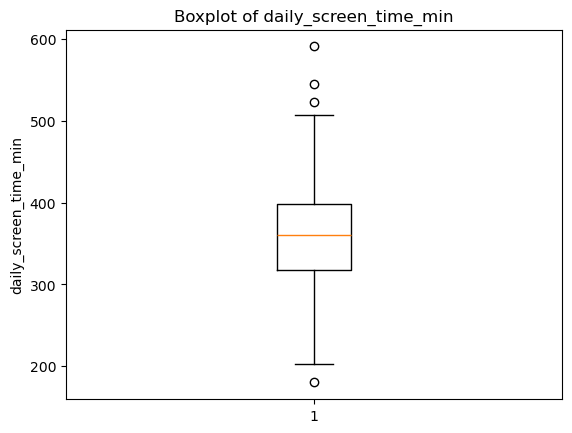

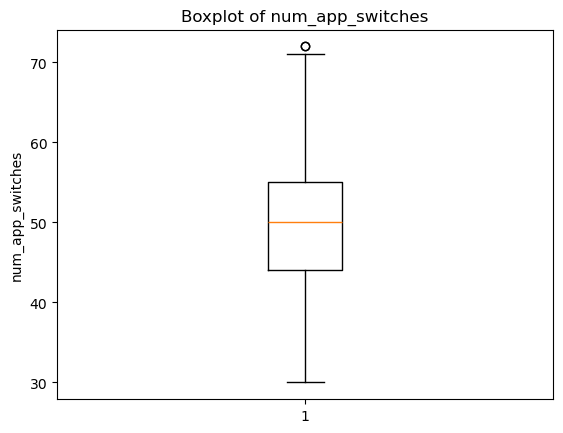

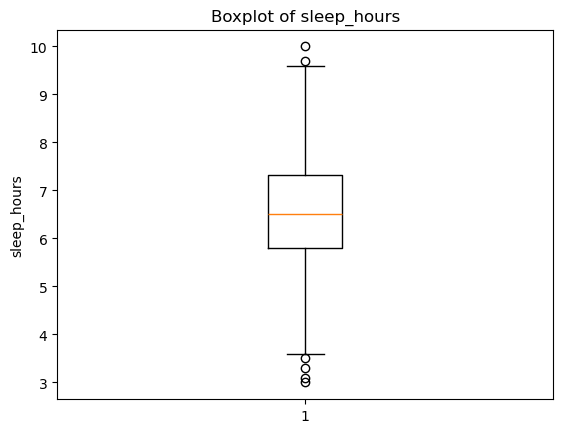

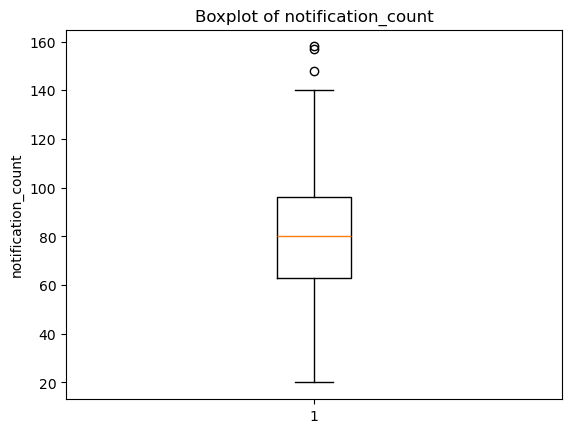

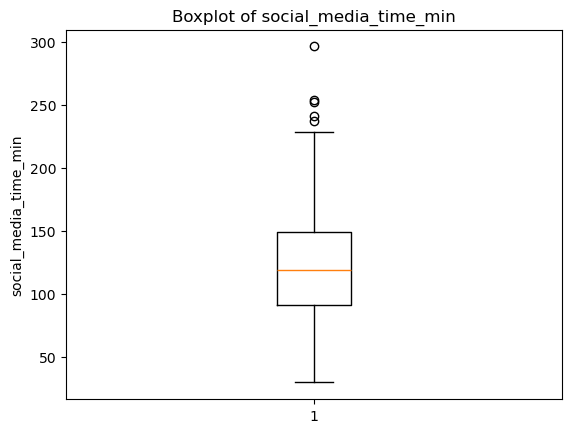

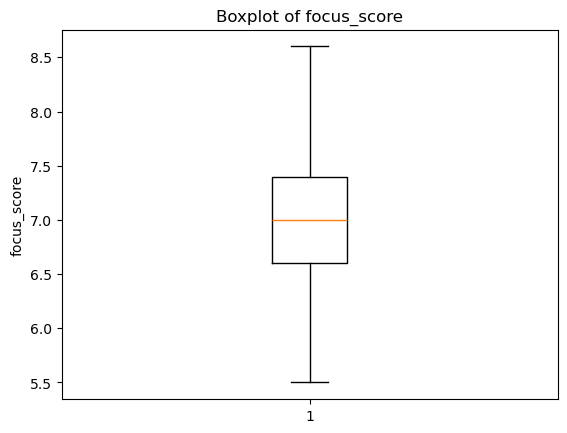

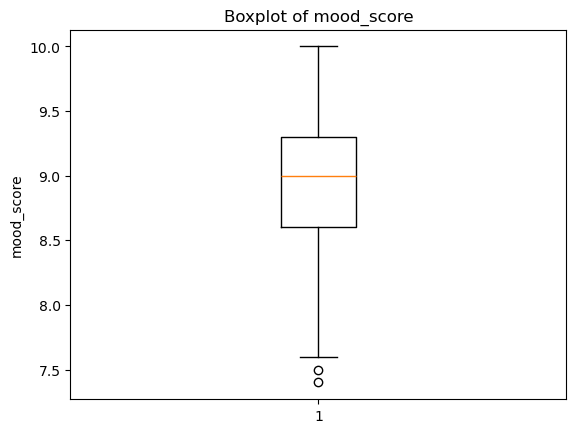

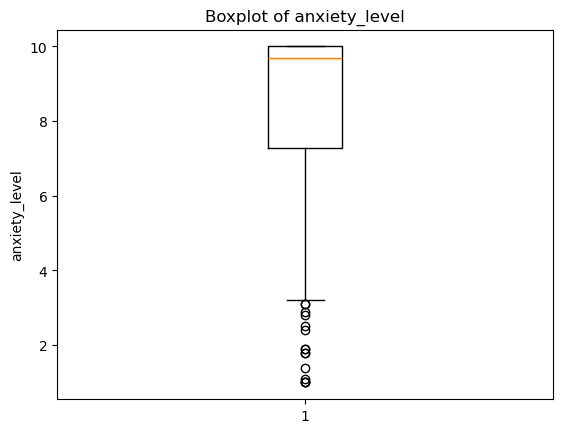

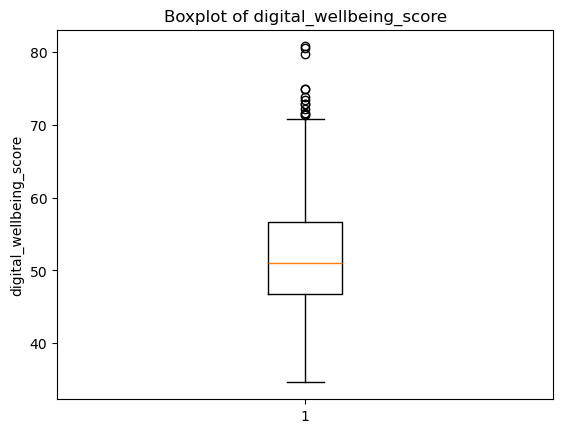

In [69]:
import matplotlib.pyplot as plt

for col in df.columns:
    plt.figure()                  
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()


In [71]:
target = 'digital_wellbeing_score'
print(f"Target column: {target}")
print(f"Range: {df[target].min()} to {df[target].max()}")


Target column: digital_wellbeing_score
Range: 34.6 to 80.8


# **Data Visualization**

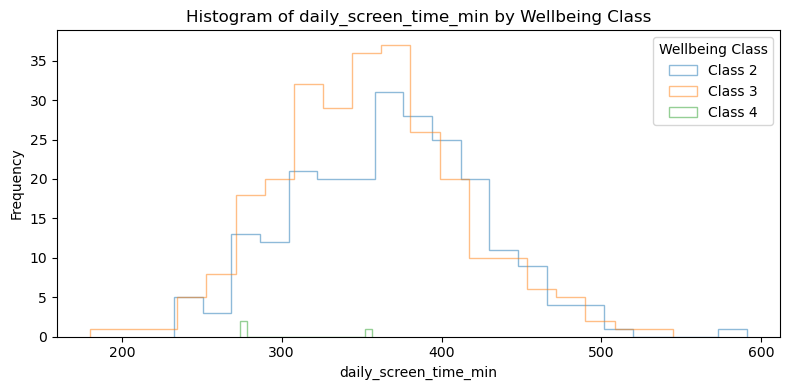

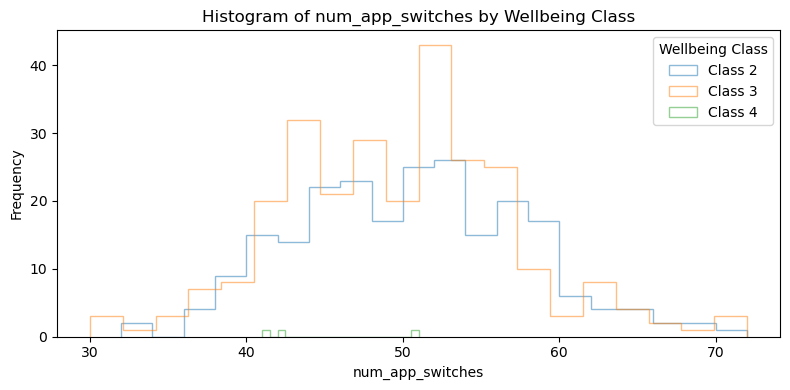

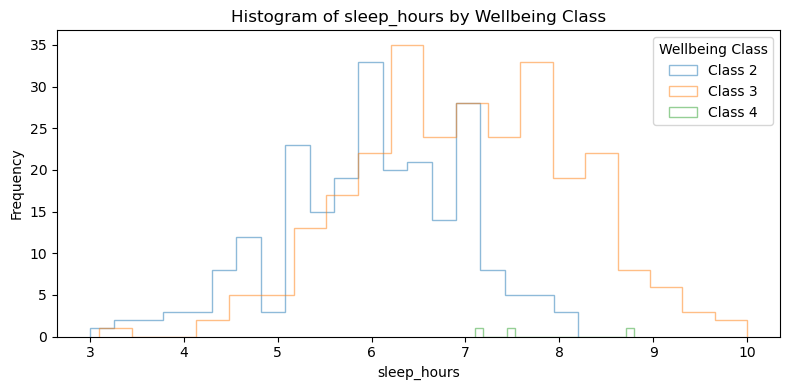

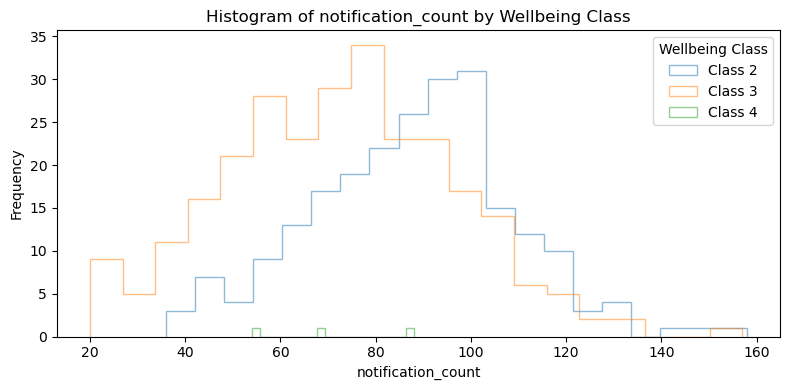

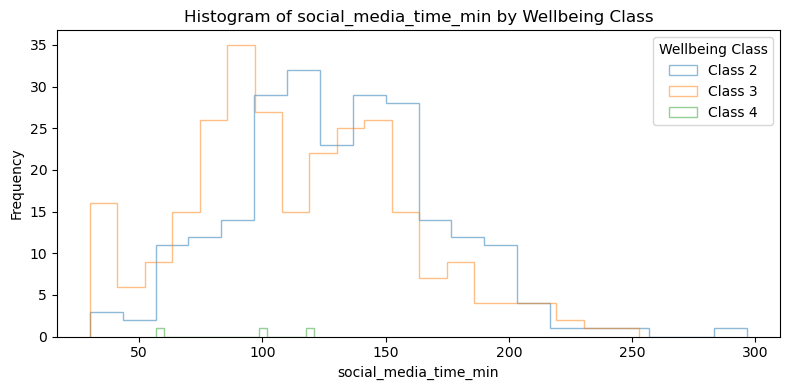

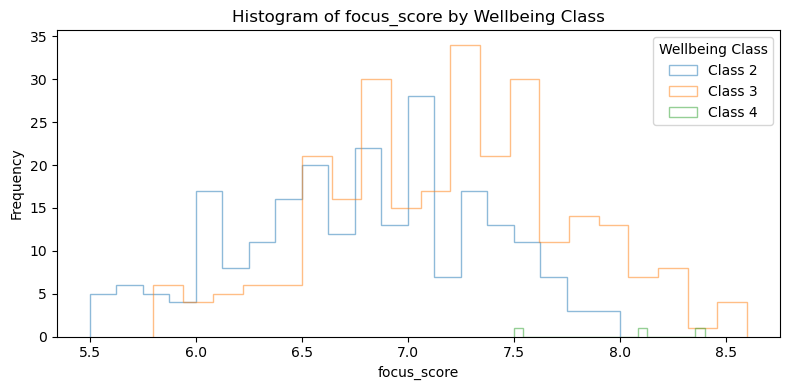

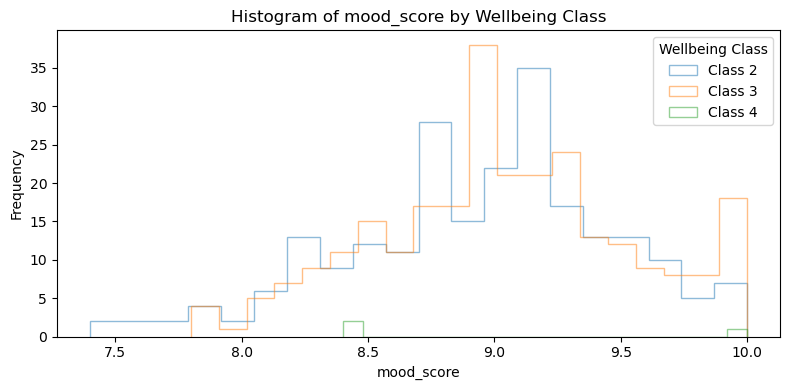

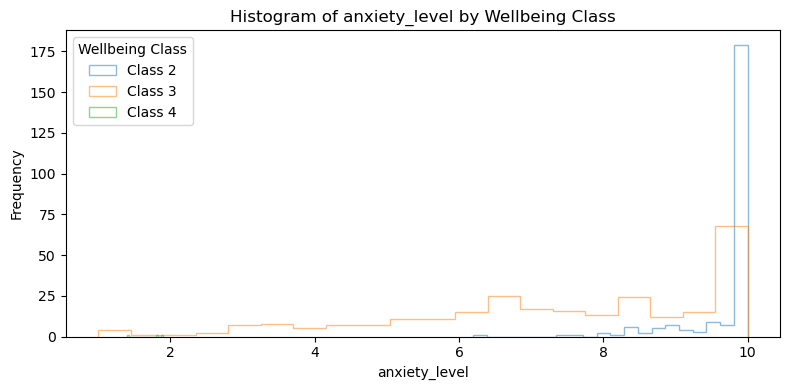

In [77]:
target = 'digital_wellbeing_score'

df['wellbeing_class'] = pd.cut(
    df[target],
    bins=[-float('inf'), 25, 50, 75, float('inf')],
    labels=['Class 1', 'Class 2', 'Class 3', 'Class 4']
)

feature_cols = [col for col in df.columns if col not in [target, 'wellbeing_class']]

for feature in feature_cols:
    plt.figure(figsize=(8, 4))
    for label in df['wellbeing_class'].unique():
        subset = df[df['wellbeing_class'] == label]
        plt.hist(subset[feature], bins=20, alpha=0.5, label=label, histtype="step")
    
    plt.title(f"Histogram of {feature} by Wellbeing Class")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(title="Wellbeing Class")
    plt.tight_layout()
    plt.show()


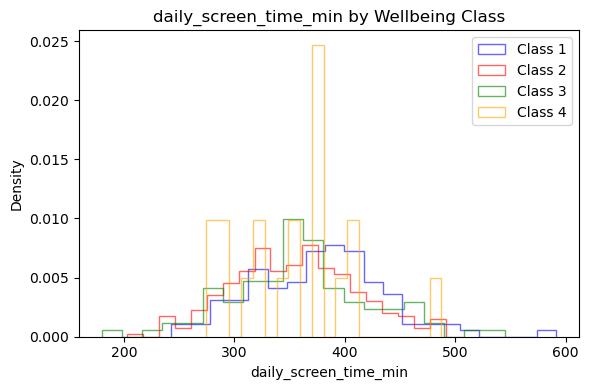

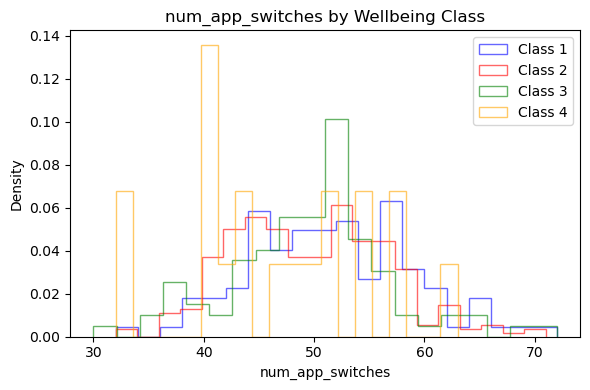

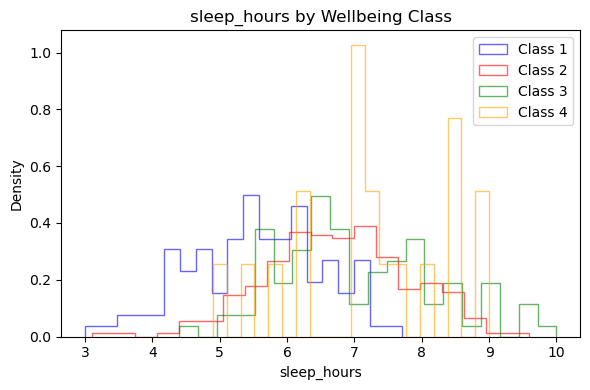

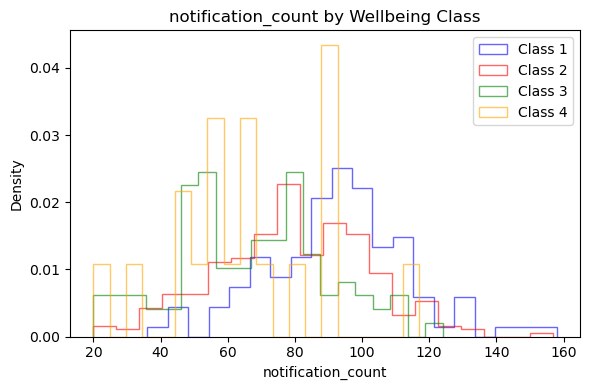

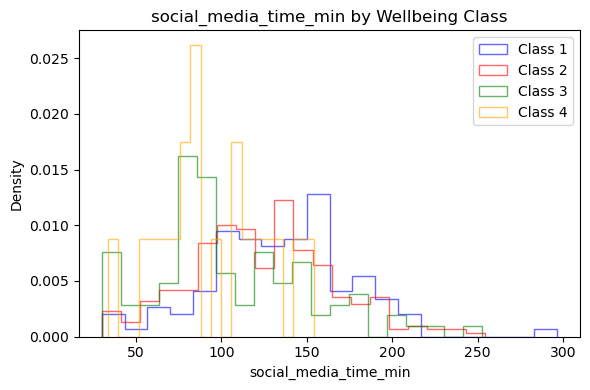

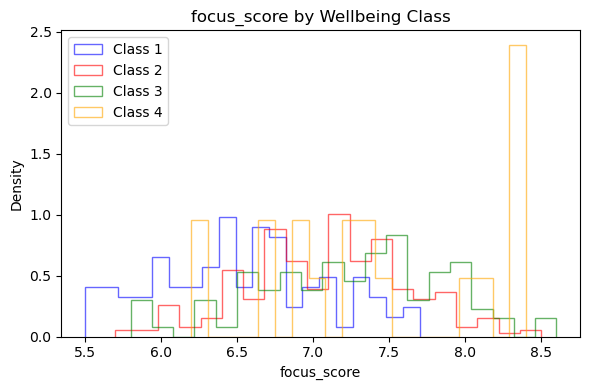

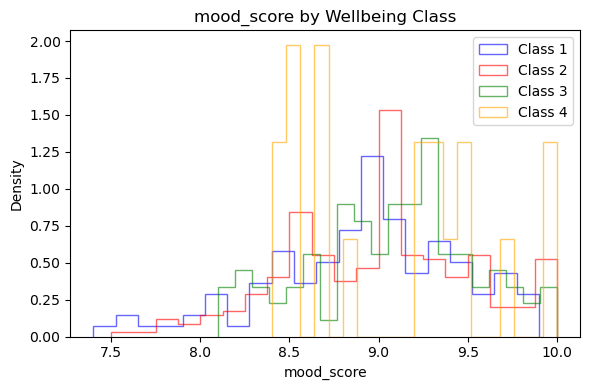

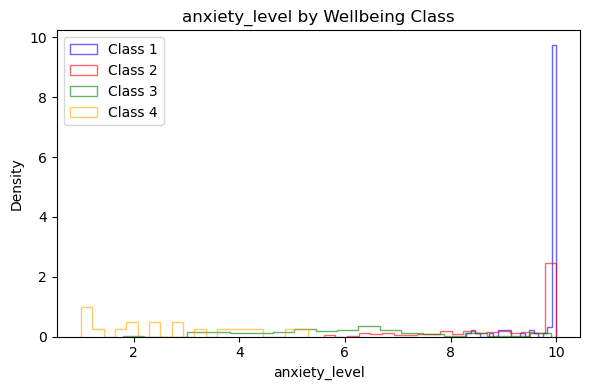

In [75]:


min_val = df["digital_wellbeing_score"].min()
max_val = df["digital_wellbeing_score"].max()
step = (max_val - min_val) / 4

bins = [min_val + i * step for i in range(5)]
labels = ["Class 1", "Class 2", "Class 3", "Class 4"]

df["wellbeing_class"] = pd.cut(df["digital_wellbeing_score"], bins=bins, labels=labels, include_lowest=True)

features = [col for col in df.columns if col not in ["digital_wellbeing_score", "wellbeing_class"]]
colors = ["blue", "red", "green", "orange"]

for feature in features:
    plt.figure(figsize=(6, 4))
    for i, cls in enumerate(labels):
        plt.hist(df[df["wellbeing_class"] == cls][feature], bins=20, alpha=0.6, label=cls, color=colors[i], density=True, histtype="step")
    plt.title(f"{feature} by Wellbeing Class")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


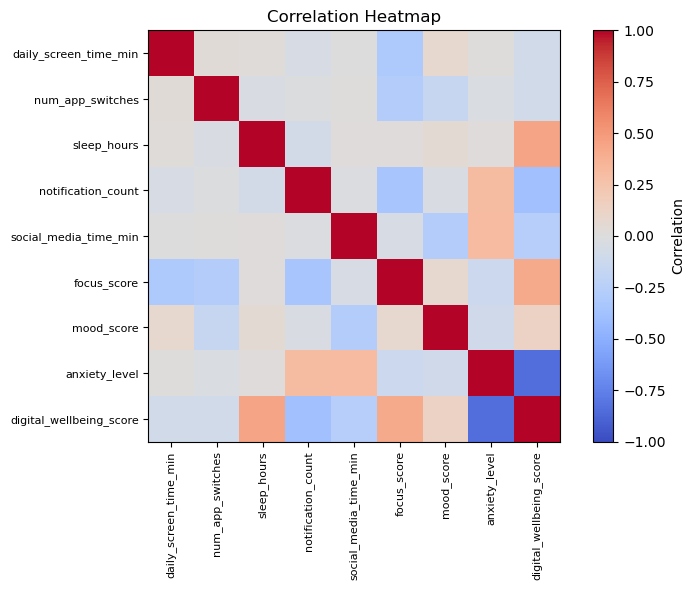

In [50]:
# Correlation
numeric_df = df.select_dtypes(include="number")

corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index, fontsize=8)
plt.title("Correlation Heatmap", fontsize=12)
plt.tight_layout()
plt.show()


# **Data Cleaning and Preperation for Machine Learning**

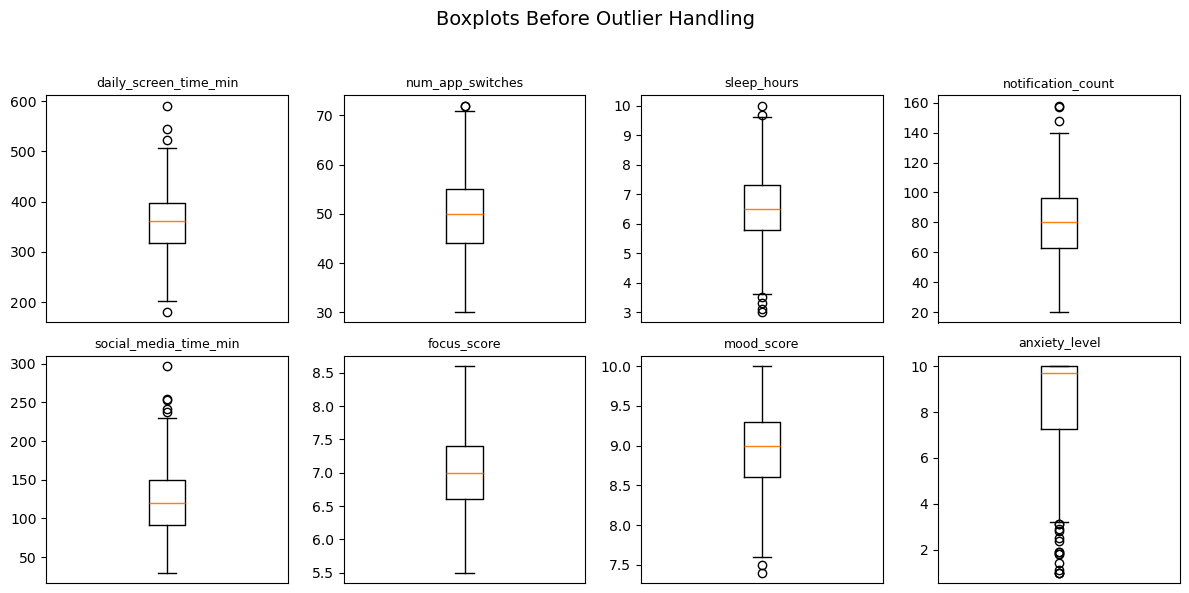

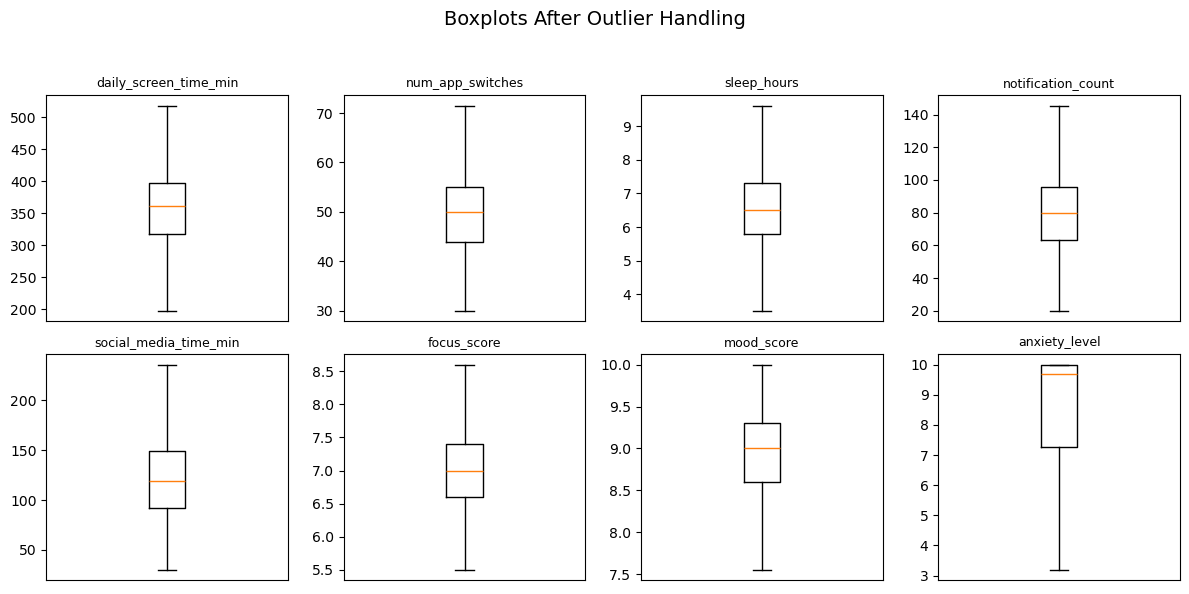

In [53]:
features = [col for col in df.columns if col not in ['digital_wellbeing_score', 'wellbeing_class']]

# boxplots before outlier handling
plt.figure(figsize=(12, 6))
plt.suptitle("Boxplots Before Outlier Handling", fontsize=14)

for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.boxplot(df[col])
    plt.title(col, fontsize=9)
    plt.xticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Apply outlier handling (clipping at 1.5×IQR)
df_cleaned = df.copy()
for col in features:
    q1, q3 = df_cleaned[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_cleaned[col] = df_cleaned[col].clip(lower=lower, upper=upper)

# boxplots after outlier handling
plt.figure(figsize=(12, 6))
plt.suptitle("Boxplots After Outlier Handling", fontsize=14)

for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.boxplot(df_cleaned[col])
    plt.title(col, fontsize=9)
    plt.xticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Why IQR?**
The IQR is a robust, non-parametric method that doesn’t assume a normal distribution.

It defines outliers as values that fall below Q1 - 1.5×IQR or above Q3 + 1.5×IQR, which is a standard statistical rule of thumb.

It is simple, interpretable, and works well for small-to-medium datasets like ours (500 rows).

**Why Clip Instead of Drop?**
Our dataset is relatively small, so removing rows with outliers would reduce valuable training data.

Instead of deleting data, we cap extreme values to the nearest acceptable limit, preserving row structure and preventing model distortion.

This avoids giving too much weight to rare, unrealistic values (e.g., excessively high screen time or zero sleep) during training.

Feature ranges before scaling:
     daily_screen_time_min  num_app_switches  sleep_hours  notification_count  \
min                197.675              30.0       3.5125                20.0   
max                518.475              71.5       9.6125               145.5   

     social_media_time_min  focus_score  mood_score  anxiety_level  
min                30.0000          5.5        7.55         3.1875  
max               235.9375          8.6       10.00        10.0000  


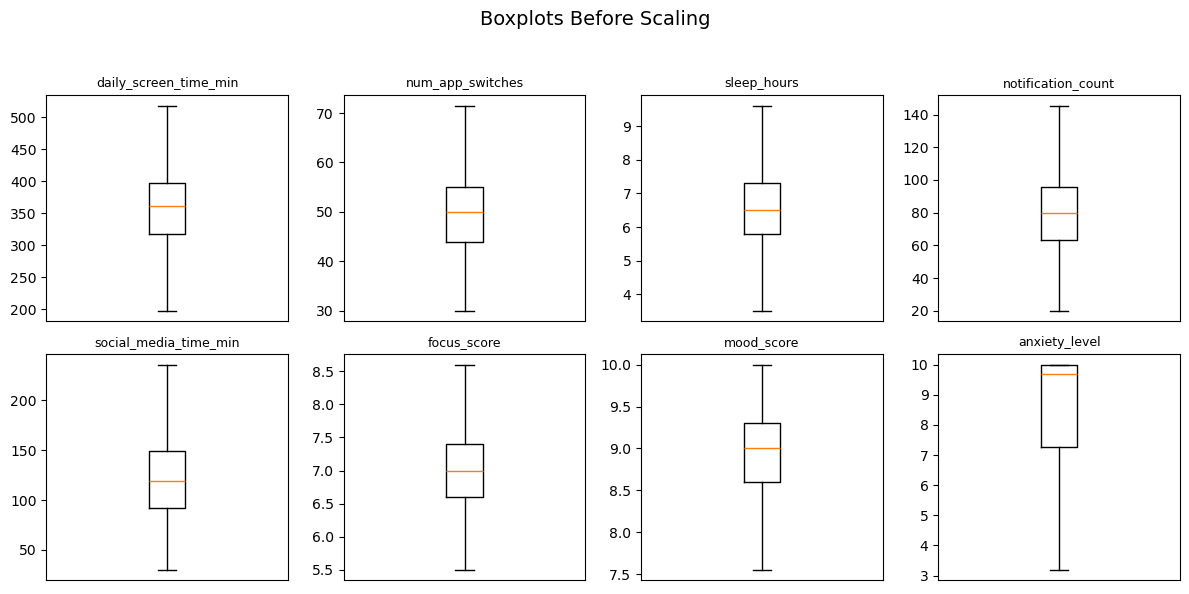

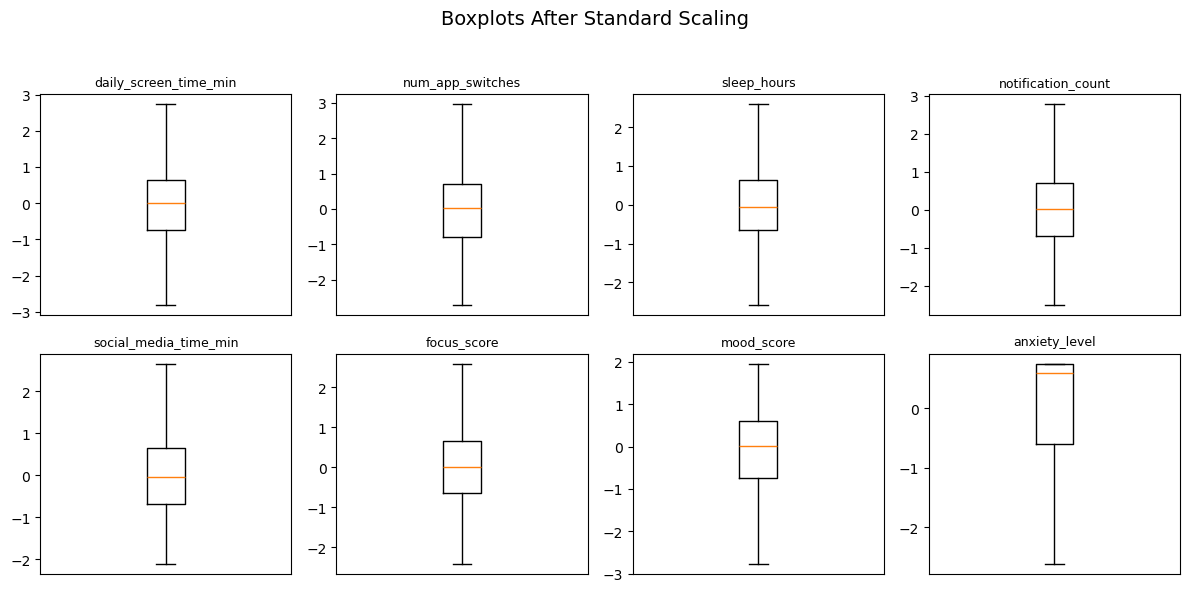

In [57]:
from sklearn.preprocessing import StandardScaler

features = [col for col in df_cleaned.columns if col not in ['digital_wellbeing_score', 'wellbeing_class']]
X = df_cleaned[features].copy()

# Check if rescaling is needed: look at feature ranges
print("Feature ranges before scaling:")
print(X.describe().loc[['min', 'max']])

# Apply StandardScaler (Z-score normalization)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# boxplots before scaling
plt.figure(figsize=(12, 6))
plt.suptitle("Boxplots Before Scaling", fontsize=14)
for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.boxplot(X[col])
    plt.title(col, fontsize=9)
    plt.xticks([])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# boxplots after scaling
plt.figure(figsize=(12, 6))
plt.suptitle("Boxplots After Standard Scaling", fontsize=14)
for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.boxplot(X_scaled[col])
    plt.title(col, fontsize=9)
    plt.xticks([])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


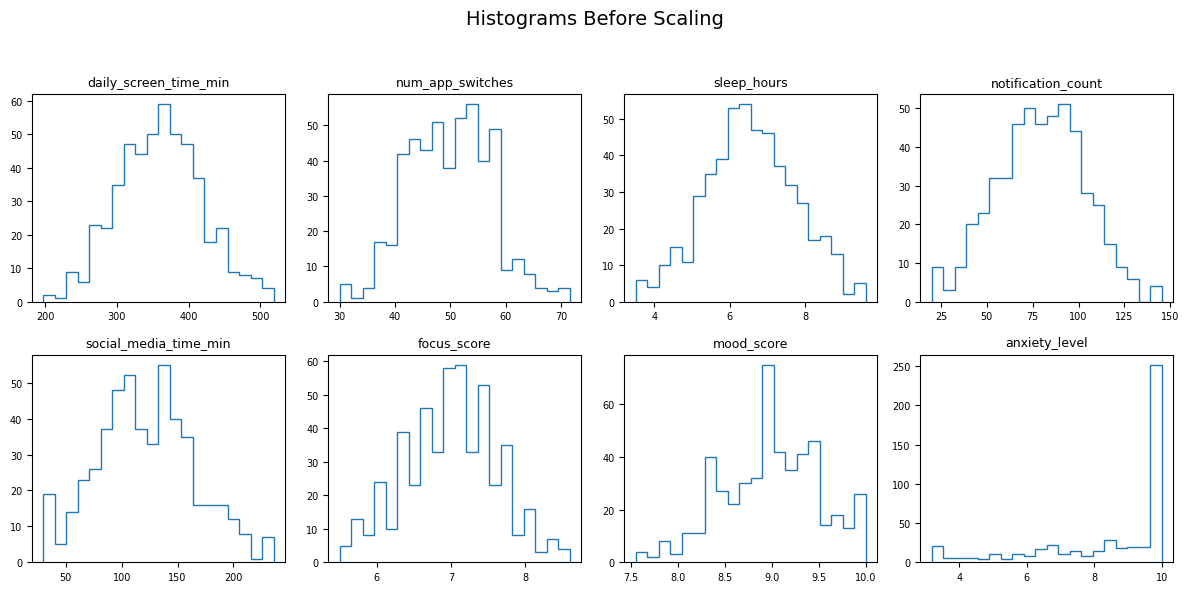

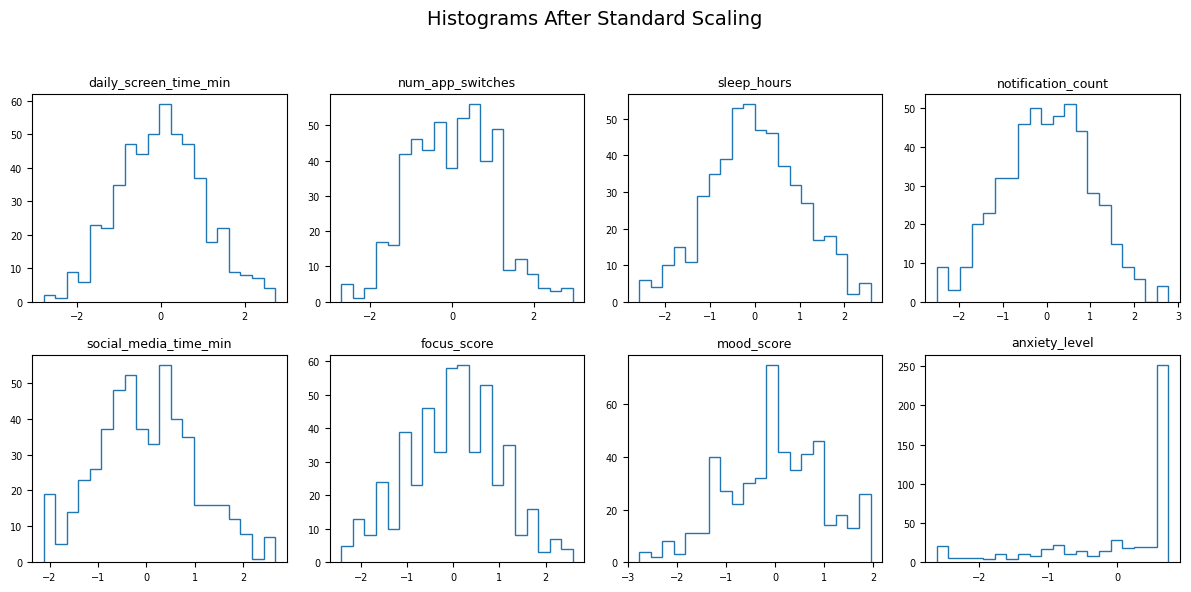

In [59]:
# Histograms before scaling
plt.figure(figsize=(12, 6))
plt.suptitle("Histograms Before Scaling", fontsize=14)
for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.hist(X[col], bins=20, histtype="step")
    plt.title(col, fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Histograms after scaling
plt.figure(figsize=(12, 6))
plt.suptitle("Histograms After Standard Scaling", fontsize=14)
for i, col in enumerate(features):
    plt.subplot(2, len(features)//2, i + 1)
    plt.hist(X_scaled[col], bins=20, histtype="step")
    plt.title(col, fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Why rescale?**
Features in this dataset have very different ranges (e.g. sleep_hours vs notification_count). This can bias ML algorithms like linear regression, KNN, or SVM which are sensitive to scale.

**Why StandardScaler (Z-score)?**
It centers the data around mean = 0 and std = 1, preserving outlier-handled distributions while making all features comparable.

# **Machine Learning Prototypes**

In [95]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Predict the mean of y_train for all test samples
y_pred_baseline = np.full_like(y_test, y_train.mean())


baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_r2 = r2_score(y_test, y_pred_baseline)


baseline_results = pd.DataFrame({
    "Model": ["Baseline (Mean Prediction)"],
    "RMSE": [round(baseline_rmse, 2)],
    "R²": [round(baseline_r2, 2)]
})

print(baseline_results)


                        Model  RMSE    R²
0  Baseline (Mean Prediction)  7.79 -0.04


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [99]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.7 MB/s eta 0:00:00


In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}


results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R²": round(r2, 2)
    })

results_df = pd.DataFrame(results)
results_df


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,RMSE,R²
0,Linear Regression,0.59,0.99
1,Random Forest,1.46,0.96
2,XGBoost,1.41,0.97


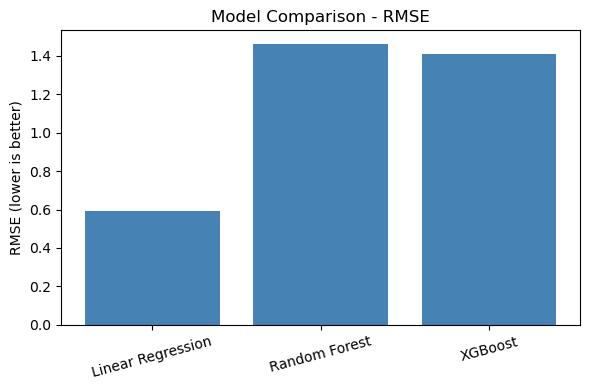

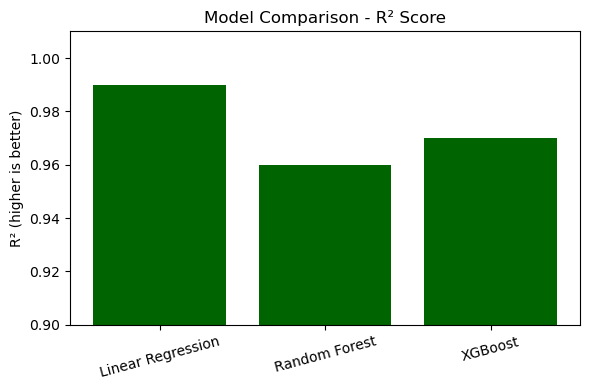

In [107]:
# Results DataFrame
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [0.59, 1.46, 1.41],
    "R²": [0.99, 0.96, 0.97]
})

# 1. Bar plot for RMSE
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["RMSE"], color="steelblue")
plt.title("Model Comparison - RMSE")
plt.ylabel("RMSE (lower is better)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. Bar plot for R²
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["R²"], color="darkgreen")
plt.title("Model Comparison - R² Score")
plt.ylabel("R² (higher is better)")
plt.xticks(rotation=15)
plt.ylim(0.90, 1.01)
plt.tight_layout()
plt.show()


The goal of this project was to determine whether we can accurately predict a person’s digital wellbeing score using their digital behavior and self-reported mental health indicators.

After cleaning the data, handling outliers, and applying feature scaling, we trained and evaluated three machine learning models: Linear Regression, Random Forest, and XGBoost.

The results show that Linear Regression performed the best, with an RMSE of 0.59 and an R² score of 0.99, meaning it explains 99% of the variance in the target variable. Both Random Forest and XGBoost also performed very well, with R² scores of 0.96 and 0.97 respectively.

These results demonstrate that it is indeed possible to accurately predict someone’s digital wellbeing score using behavioral data such as daily screen time, num app switches, sleep hours, notification count, social media time, focus,  mood, and anxiety level.

In conclusion, the project successfully solved the initial problem and showed that machine learning can be a valuable tool for analyzing and predicting mental wellbeing based on digital behavior.